# Import All Neccessary:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("arrest_data.csv")

## CLEAN DATA:

In [4]:
#Gets rid of any columns with blank data
df_clean = df[df['INCIDENTNEIGHBORHOOD'].notna()]
#Since we are looking at neighborhoods within the city, we will omit anything outside of the Greater Pittsburgh Region. 
df_clean = df_clean[df_clean['INCIDENTNEIGHBORHOOD'] != "Outside City"]
df_clean.head()

,_id,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551
2,3,1974466,16144165,63.0,F,B,2016-08-03T16:45:00,"900 Block Freeport RD Fox Chapel, PA 15238",3929 Retail Theft.,"900 Block Freeport RD Fox Chapel, PA 15238",Westwood,5,2811.0,9.0,2.0,-79.891803,40.486625
3,4,1974550,16145257,25.0,F,W,2016-08-05T02:36:00,"Foreland ST & Cedar AV Pittsburgh, PA 15212",5503 Disorderly Conduct. / 5505 Public Drunken...,"Foreland ST & Cedar AV Pittsburgh, PA 15212",East Allegheny,1,2304.0,1.0,1.0,-80.001939,40.454080
4,5,1974596,16145962,25.0,M,B,2016-08-06T02:00:00,"900 Block Woodlow ST Pittsburgh, PA 15205",2702 Aggravated Assault. / 2705 Recklessy Enda...,"900 Block Woodlow ST Pittsburgh, PA 15205",Crafton Heights,5,2814.0,2.0,5.0,-80.052204,40.445900
5,6,1974556,16144301,45.0,M,W,2016-08-15T13:30:00,"600 Block 1st AV Pittsburgh, PA 15219",3929 Retail Theft.,"800 Block Hazelwood AV Pittsburgh, PA 15217",Greenfield,4,1517.0,5.0,3.0,-79.929238,40.419699


## BASIC ANALYSIS:

In [5]:
arrest_counts = df_clean['INCIDENTNEIGHBORHOOD'].value_counts().reset_index()
arrest_counts.columns = ['Neighborhood', 'Arrest Count']

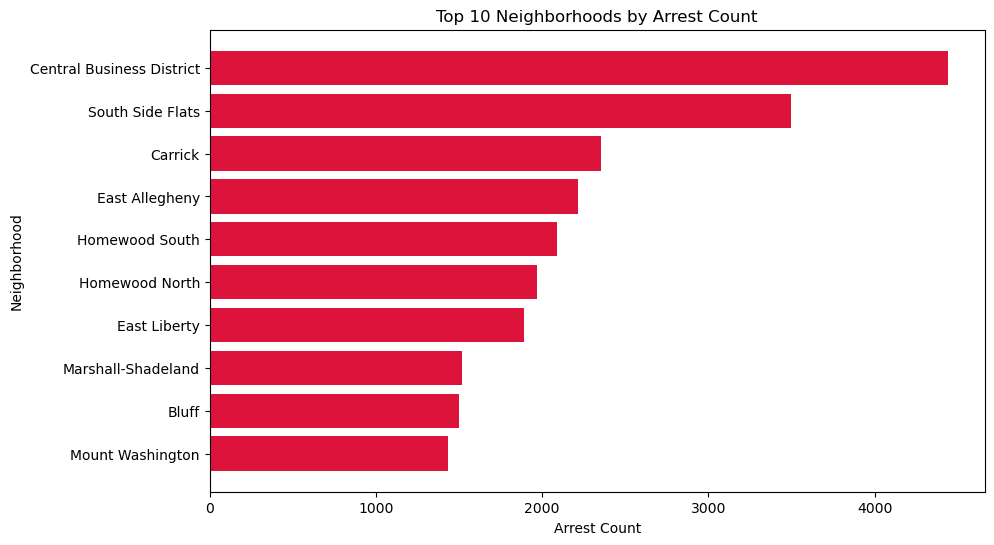

In [6]:
#Most Arrests:
top_10 = arrest_counts.head(10)
#PLOT
plt.figure(figsize=(10,6))
plt.barh(top_10['Neighborhood'], top_10['Arrest Count'], color='crimson')
plt.gca().invert_yaxis()
plt.title("Top 10 Neighborhoods by Arrest Count")
plt.xlabel("Arrest Count")
plt.ylabel("Neighborhood")
plt.show()


### Observation: CENTRAL BUSINESS DISTRICT MOST ARRESTS

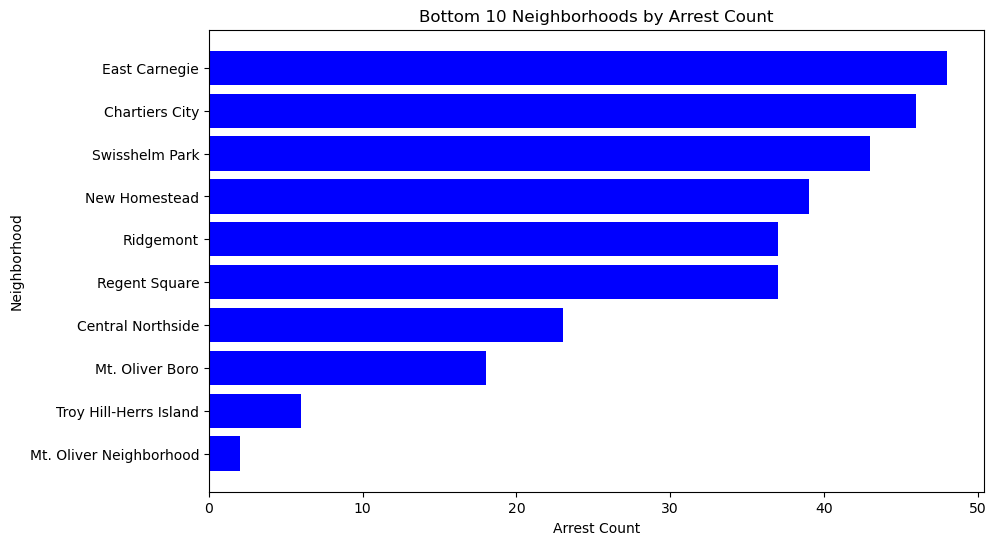

In [7]:
#Least Arrests:
least_10 = arrest_counts.tail(10)
#PLOT
plt.figure(figsize=(10,6))
plt.barh(least_10['Neighborhood'], least_10['Arrest Count'], color='blue')
plt.gca().invert_yaxis()
plt.title("Bottom 10 Neighborhoods by Arrest Count")
plt.xlabel("Arrest Count")
plt.ylabel("Neighborhood")
plt.show()


### Observation: Mt.Oliver Neighborhood LEAST ARRESTS

## ADVANCED ANALYSIS:

In [8]:
df_clean['OFFENSES'] = df_clean['OFFENSES'].fillna('').str.lower()
df_clean['OFFENSES'] = df_clean['OFFENSES'].str.lower()

In [9]:
# Assign severity to offenses (in consideration with the other offenses from the list)
def classify_severity(offense):
    if 'aggravated assault' in offense or 'strangulation' in offense or 'terroristic threats' in offense:
        return 5
    elif 'simple assault' in offense or 'bench warrant' in offense or 'failure to appear' in offense:
        return 4
    elif 'dui' in offense or 'retail theft' in offense or 'theft' in offense or 'receiving stolen property' in offense:
        return 3
    elif 'controlled substance' in offense or 'marijuana' in offense or 'paraphernalia' in offense or 'contempt' in offense:
        return 2
    else:
        return 1

df_clean['Severity'] = df_clean['OFFENSES'].apply(classify_severity)


In [16]:
# Find the average severity by neighborhood
severity_by_neighborhood = df_clean.groupby('INCIDENTNEIGHBORHOOD')['Severity'].mean().reset_index()
severity_by_neighborhood.columns = ['Neighborhood', 'Average Severity']

# Count arrests by neighborhood
arrest_counts = df_clean['INCIDENTNEIGHBORHOOD'].value_counts().reset_index()
arrest_counts.columns = ['Neighborhood', 'Arrest Count']

# Merge severity and arrest count data
combined_df = pd.merge(arrest_counts, severity_by_neighborhood, on='Neighborhood')

# Filter to only Central Business District and Mt. Oliver
filtered_df_severity = combined_df[combined_df['Neighborhood'].isin(['Central Business District', 'Mt. Oliver Neighborhood'])]

filtered_df_severity

,Neighborhood,Arrest Count,Average Severity
0,Central Business District,4440,2.925
96,Mt. Oliver Neighborhood,2,2.500


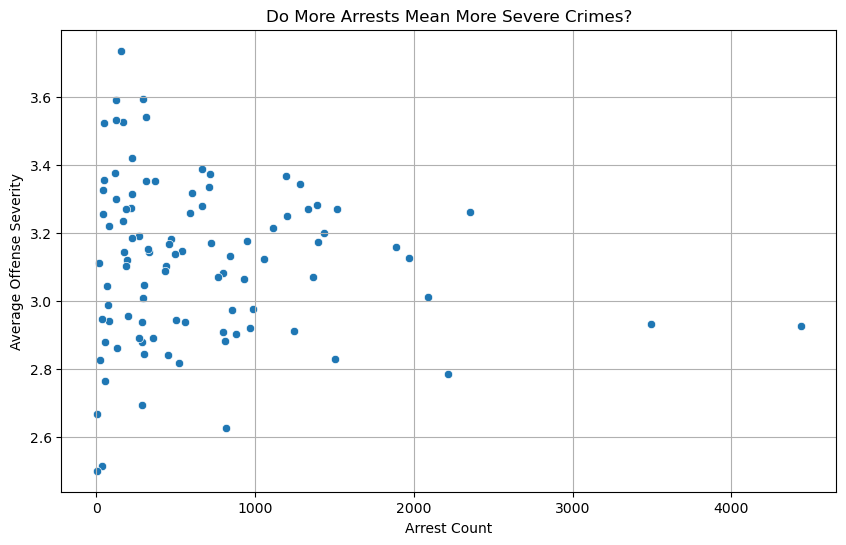

Correlation: -0.08


In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='Arrest Count', y='Average Severity')
plt.title('Do More Arrests Mean More Severe Crimes?')
plt.xlabel('Arrest Count')
plt.ylabel('Average Offense Severity')
plt.grid(True)
plt.show()


correlation = combined_df['Arrest Count'].corr(combined_df['Average Severity'])
print(f"Correlation: {correlation:.2f}")

In [13]:
severe_df = df_clean[df_clean['Severity'] >= 4]
severe_percent = severe_df.groupby('INCIDENTNEIGHBORHOOD').size() / df_clean.groupby('INCIDENTNEIGHBORHOOD').size()
severe_percent = severe_percent.dropna().sort_values(ascending=False)

filtered_neighborhoods = severe_percent.loc[
    ['Central Business District', 'Mt. Oliver Neighborhood']
]
print(filtered_neighborhoods)

INCIDENTNEIGHBORHOOD
Central Business District    0.426577
Mt. Oliver Neighborhood      0.500000
dtype: float64


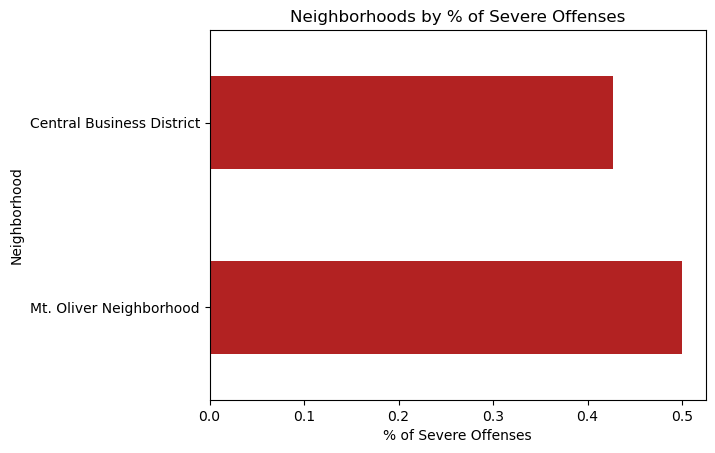

In [14]:
filtered_neighborhoods.head(10).plot(kind = 'barh',color='firebrick')
plt.title('Neighborhoods by % of Severe Offenses')
plt.xlabel('% of Severe Offenses')
plt.ylabel('Neighborhood')
plt.gca().invert_yaxis()
plt.show()

### Personal Conclusion: 

After analyzing the arrest data, I concluded that the Central Business District is the least responsible neighborhood. On the other hand, Mt. Oliver is the most responsible neighborhood based on arrest data. The Central Business District totals 4400 arrests, while Mt. Oliver totals only 2 arrests! This vast difference can be attributed to the difference in population for both neighborhoods and civilian activity. 